read about perlin noise for initial landscape
https://en.wikipedia.org/wiki/Perlin_noise

This notebook focuses only on the Landslide element of the cell automata

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML


plt.rcParams["animation.html"] = "jshtml"

In [2]:
tmap = np.zeros((10, 10))
tmap[5, 5] = 10

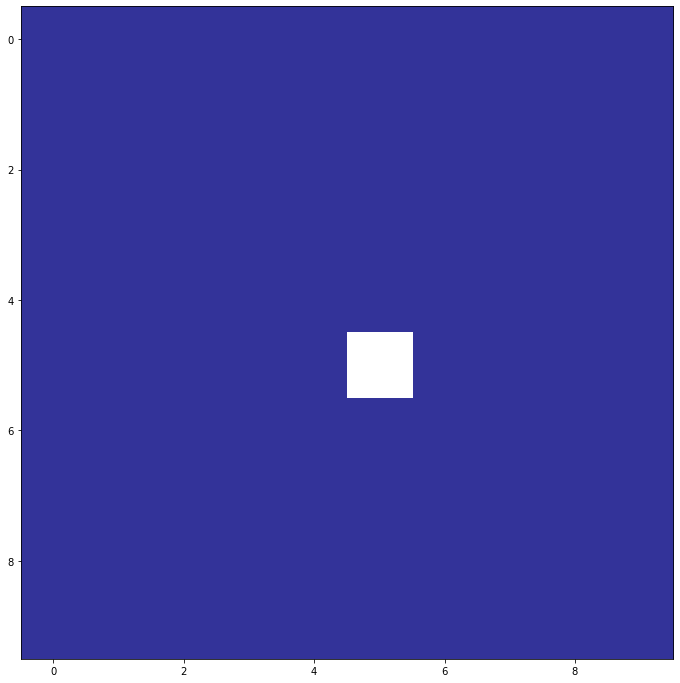

In [3]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(tmap, cmap=plt.cm.terrain)
fig.savefig("map.png")

In [4]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

class CellStepNaive(object):
    def __init__(self, canvas):
        self.canvas = copy.deepcopy(canvas)
        self.canvas_padded = np.pad(canvas, pad_width=1, mode="edge")

    
        self.imap = np.arange(len(self.canvas.flatten())).reshape(self.canvas.shape)
        self.imap_padded = np.arange(len(self.canvas_padded.flatten())).reshape(self.canvas_padded.shape)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
    
    def step(self):
        """
        Water flows downhill into the ocean, from each point on and on
        
        
        This is the from out to in phylosophy, where water flow is calculated from other to here for each cell
        
        This is equivalent to the in to out phylosophy, just easier to implement vectorized
        """
        
        self.height_local = self.canvas
        self.height_shifted = np.array([self.canvas_padded.flat[ii] for ii in self.imap_shifted])
#         print(self.canvas)
        self.diffs = (self.height_local - self.height_shifted) # how much higher the neighbor cell is than this
        self.diffs[self.diffs < 0] = 0
        fractions = np.nan_to_num(self.diffs / self.diffs.sum(axis=0))
        landslide = self.diffs.sum(axis=0) * fractions *0.2# this is how much matter leaves this cell in each direction
#         print(landslide)
        self.height_local -= landslide.sum(axis=0)
        self.landslide = []
        for i, ii in enumerate(self.imap_unshifted):
            tmp = np.pad(landslide[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            self.landslide.append(tmp)
        self.landslide = np.array(self.landslide)
        self.height_local += self.landslide.sum(axis=0)
        
        self.canvas = self.height_local
        self.canvas_padded = np.pad(self.canvas, pad_width=1, mode="edge")
#         print(self.canvas.sum())

    def flow(self, nstep=100):
        self.maps = []
        self.maps.append(self.canvas.copy())
        for i in np.arange(nstep):
            print(str(i) + ' out of ' + str(nstep-1), end="\r")
            self.step()
            self.maps.append(self.canvas.copy())

In [5]:
cs = CellStepNaive(tmap)
cs.flow(1)

/tmp/ipykernel_3886/2275101129.py:79: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(self.diffs / self.diffs.sum(axis=0))


In [6]:
maps = cs.maps

In [7]:
maps

[array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 2., 2., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

In [8]:
maps[3].sum()

IndexError: list index out of range

# A generalized cell automata with optimized calculation

In [189]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for key in self.layers:
            rl = self.rules[key]
            canvas = rl.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
            print(str(i) + ' out of ' + str(nstep-1), end="\r")
            self.step()
            self.update_maps()

In [261]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        self.key = "terrain"
        self.flow_factor = flow_factor
        
    def evolve(self, cell):
        self.height_local = cell.canvases[self.key]
        self.height_shifted = cell.shifted_canvases[self.key]
        
        diffs = self.height_local - self.height_shifted
        diffs[diffs < 0] = 0
        
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        self.outflow = diffs * fractions * self.flow_factor # this is the outgoing amount
        
        self.calc_flows(cell)
        resdict = {self.key: self.height_local}
        return resdict
        
    def calc_flows(self, cell):
        self.height_local -= self.outflow.sum(axis=0)
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(self.outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        print(shifted_landslide.sum(axis=0))
        self.height_local += shifted_landslide.sum(axis=0)        
         

class Landslide(FlowRule):
    def __init__(self, flow=0.5):
        
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.key = "terrain"
        self.erosion_factor = erosion_factor
    
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        landslide = diffs * fractions * self.erosion_factor # this is the outgoing amount
        
        height_local -= landslide.sum(axis=0)
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(landslide[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        print(shifted_landslide.sum(axis=0))
        height_local += shifted_landslide.sum(axis=0)        

        resdict = {self.key: height_local}
        return resdict
        
    

In [262]:
tmap = np.zeros((5, 5))
tmap[1, 1] = 100

initial_maps = {
    "terrain": tmap,
}
rules = {
#     "terrain": Landslide(erosion_factor=0.4),
    "terrain": FlowRule(flow_factor=0.4)
}
key = "terrain"

In [263]:
cs = CellSpace(initial_maps, rules)
cs.flow(200)

[[ 0. 10.  0.  0.  0.]
 [10.  0. 10.  0.  0.]
 [ 0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[4.         5.         3.33333333 0.         0.        ]
 [5.         0.         5.         1.33333333 0.        ]
 [3.33333333 5.         2.66666667 0.         0.        ]
 [0.         1.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[2.67272727 2.9        2.51904762 1.51111111 0.        ]
 [2.9        0.         2.9        1.45627706 0.17777778]
 [2.51904762 2.9        2.16450216 0.71111111 0.        ]
 [1.51111111 1.45627706 0.71111111 0.         0.        ]
 [0.         0.17777778 0.         0.         0.        ]]
[[1.37087559 1.71855671 2.22245096 1.25401404 0.64      ]
 [1.71855671 0.         1.82158702 1.28988069 0.39554371]
 [2.22245096 1.82158702 1.71702145 0.82927561 0.17777778]
 [1.25401404 1.28988069 0.82927561 0.28444444 0.        ]
 [0.64       0.39554371 0.17777778 0.         0.        ]]
[[0.6319107

/tmp/ipykernel_3886/530907724.py:13: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


In [264]:
cs.maps["terrain"][-1]

array([[4.00000012, 4.00000009, 4.00000005, 4.00000001, 3.99999998],
       [4.00000009, 4.00000007, 4.00000003, 3.99999999, 3.99999997],
       [4.00000005, 4.00000003, 4.        , 3.99999997, 3.99999995],
       [4.00000001, 3.99999999, 3.99999997, 3.99999994, 3.99999993],
       [3.99999998, 3.99999997, 3.99999995, 3.99999993, 3.99999992]])

/tmp/ipykernel_3886/916744141.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig =plt.figure()


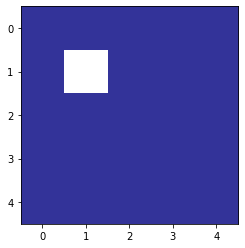

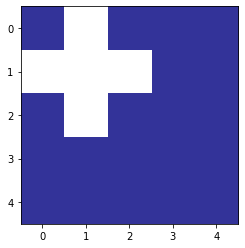

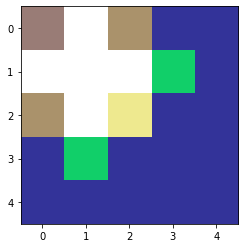

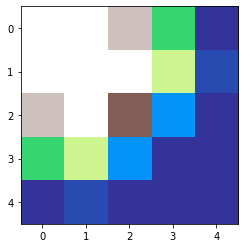

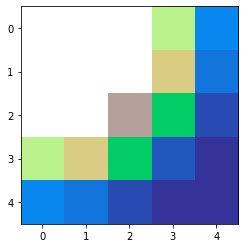

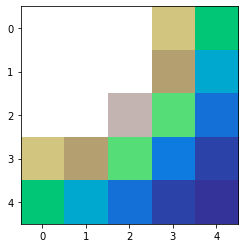

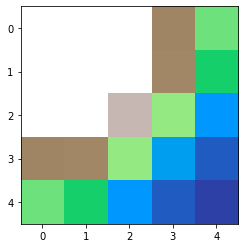

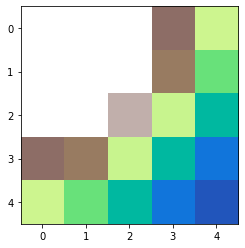

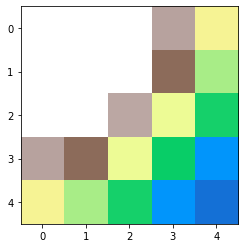

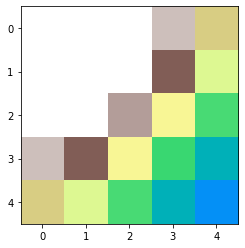

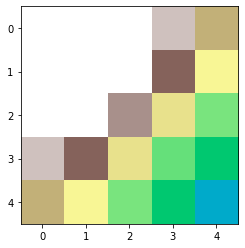

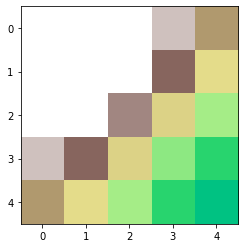

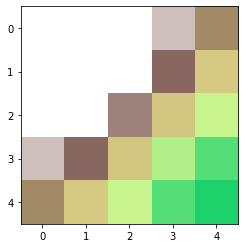

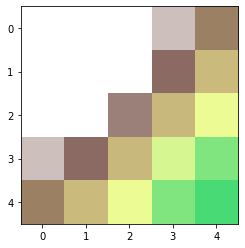

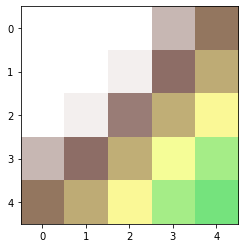

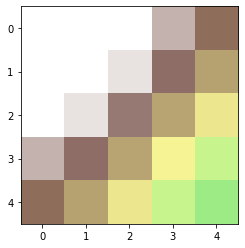

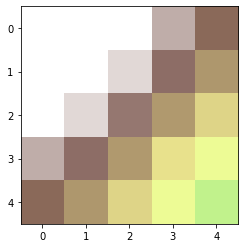

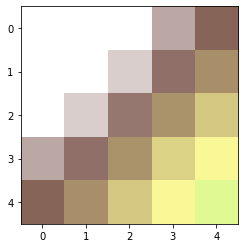

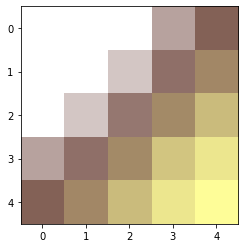

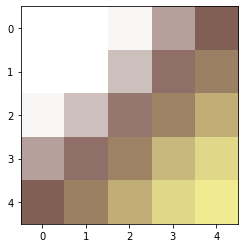

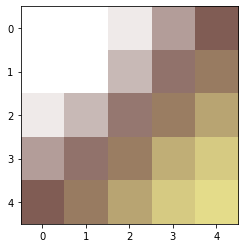

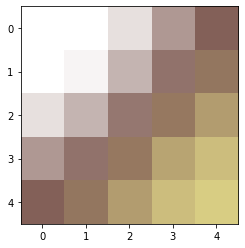

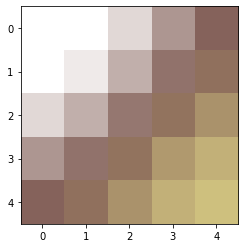

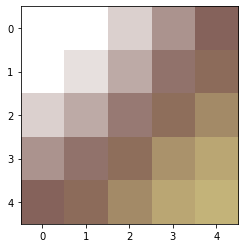

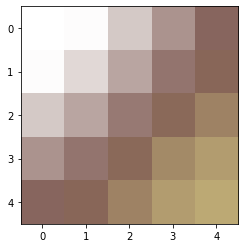

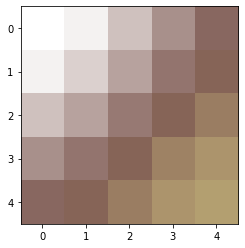

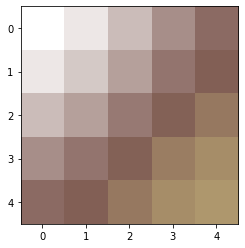

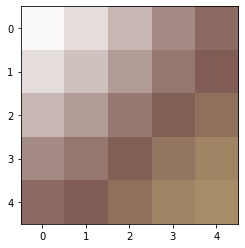

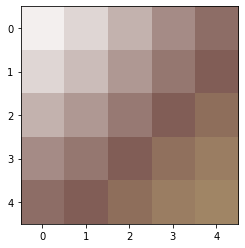

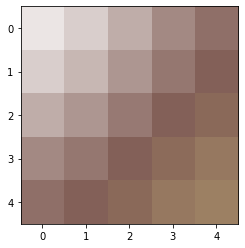

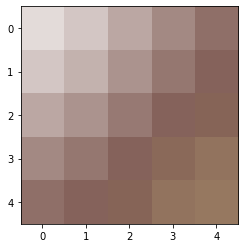

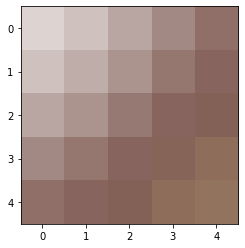

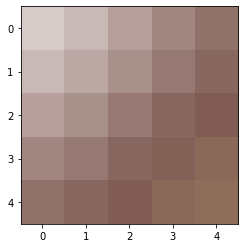

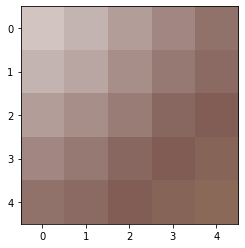

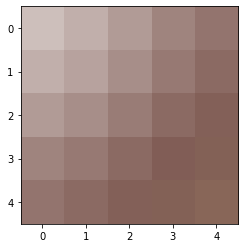

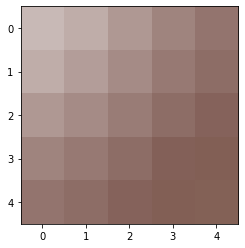

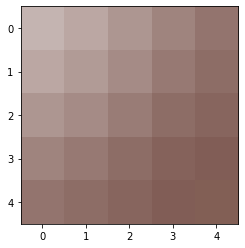

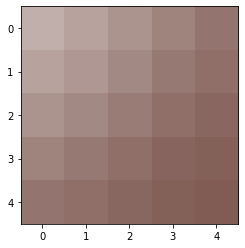

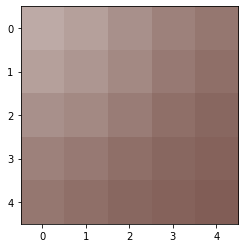

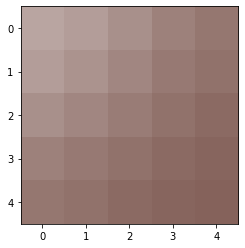

In [265]:
for i in np.arange(40):
    fig =plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(cs.maps["terrain"][i], cmap="terrain", vmin=0, vmax=5)

In [266]:
cs.flow(1000)

[[0.00000000e+00 5.19670333e-09 8.89714345e-09 9.76084658e-09
  7.57358124e-09]
 [5.19670333e-09 8.82282723e-09 1.12153000e-08 1.10527299e-08
  1.10232686e-08]
 [8.89714345e-09 1.12153000e-08 1.23959612e-08 1.15416982e-08
  1.16256554e-08]
 [9.76084658e-09 1.10527299e-08 1.15416982e-08 1.02932908e-08
  9.63368487e-09]
 [7.57358124e-09 1.10232686e-08 1.16256554e-08 9.63368487e-09
  6.92951119e-09]]
[[0.00000000e+00 4.74039261e-09 8.11590557e-09 8.90376893e-09
  6.90856223e-09]
 [4.74039261e-09 8.04811457e-09 1.02305103e-08 1.00822146e-08
  1.00553408e-08]
 [8.11590557e-09 1.02305103e-08 1.13074995e-08 1.05282482e-08
  1.06048322e-08]
 [8.90376893e-09 1.00822146e-08 1.05282482e-08 9.38946027e-09
  8.78777371e-09]
 [6.90856223e-09 1.00553408e-08 1.06048322e-08 8.78777371e-09
  6.32104573e-09]]
[[0.00000000e+00 4.32414957e-09 7.40326667e-09 8.12194895e-09
  6.30193715e-09]
 [4.32414957e-09 7.34142782e-09 9.33219223e-09 9.19691855e-09
  9.17240354e-09]
 [7.40326667e-09 9.33219223e-09 1.0314

/tmp/ipykernel_3886/530907724.py:13: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


[[0.00000000e+00 1.77635684e-16 1.77635684e-16 1.77635684e-16
  3.55271368e-16]
 [1.77635684e-16 3.55271368e-16 3.55271368e-16 0.00000000e+00
  1.77635684e-16]
 [1.77635684e-16 3.55271368e-16 0.00000000e+00 3.55271368e-16
  0.00000000e+00]
 [1.77635684e-16 0.00000000e+00 3.55271368e-16 0.00000000e+00
  0.00000000e+00]
 [3.55271368e-16 1.77635684e-16 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
[[0.00000000e+00 1.77635684e-16 1.77635684e-16 1.77635684e-16
  3.55271368e-16]
 [1.77635684e-16 3.55271368e-16 3.55271368e-16 0.00000000e+00
  1.77635684e-16]
 [1.77635684e-16 3.55271368e-16 0.00000000e+00 3.55271368e-16
  0.00000000e+00]
 [1.77635684e-16 0.00000000e+00 3.55271368e-16 0.00000000e+00
  0.00000000e+00]
 [3.55271368e-16 1.77635684e-16 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
[[0.00000000e+00 1.77635684e-16 1.77635684e-16 1.77635684e-16
  3.55271368e-16]
 [1.77635684e-16 3.55271368e-16 3.55271368e-16 0.00000000e+00
  1.77635684e-16]
 [1.77635684e-16 3.55271368e-16 0.0000

[[0.00000000e+00 1.77635684e-16 1.77635684e-16 1.77635684e-16
  3.55271368e-16]
 [1.77635684e-16 3.55271368e-16 3.55271368e-16 0.00000000e+00
  1.77635684e-16]
 [1.77635684e-16 3.55271368e-16 0.00000000e+00 3.55271368e-16
  0.00000000e+00]
 [1.77635684e-16 0.00000000e+00 3.55271368e-16 0.00000000e+00
  0.00000000e+00]
 [3.55271368e-16 1.77635684e-16 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
[[0.00000000e+00 1.77635684e-16 1.77635684e-16 1.77635684e-16
  3.55271368e-16]
 [1.77635684e-16 3.55271368e-16 3.55271368e-16 0.00000000e+00
  1.77635684e-16]
 [1.77635684e-16 3.55271368e-16 0.00000000e+00 3.55271368e-16
  0.00000000e+00]
 [1.77635684e-16 0.00000000e+00 3.55271368e-16 0.00000000e+00
  0.00000000e+00]
 [3.55271368e-16 1.77635684e-16 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
[[0.00000000e+00 1.77635684e-16 1.77635684e-16 1.77635684e-16
  3.55271368e-16]
 [1.77635684e-16 3.55271368e-16 3.55271368e-16 0.00000000e+00
  1.77635684e-16]
 [1.77635684e-16 3.55271368e-16 0.0000

[[0.00000000e+00 1.77635684e-16 1.77635684e-16 1.77635684e-16
  3.55271368e-16]
 [1.77635684e-16 3.55271368e-16 3.55271368e-16 0.00000000e+00
  1.77635684e-16]
 [1.77635684e-16 3.55271368e-16 0.00000000e+00 3.55271368e-16
  0.00000000e+00]
 [1.77635684e-16 0.00000000e+00 3.55271368e-16 0.00000000e+00
  0.00000000e+00]
 [3.55271368e-16 1.77635684e-16 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
[[0.00000000e+00 1.77635684e-16 1.77635684e-16 1.77635684e-16
  3.55271368e-16]
 [1.77635684e-16 3.55271368e-16 3.55271368e-16 0.00000000e+00
  1.77635684e-16]
 [1.77635684e-16 3.55271368e-16 0.00000000e+00 3.55271368e-16
  0.00000000e+00]
 [1.77635684e-16 0.00000000e+00 3.55271368e-16 0.00000000e+00
  0.00000000e+00]
 [3.55271368e-16 1.77635684e-16 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
[[0.00000000e+00 1.77635684e-16 1.77635684e-16 1.77635684e-16
  3.55271368e-16]
 [1.77635684e-16 3.55271368e-16 3.55271368e-16 0.00000000e+00
  1.77635684e-16]
 [1.77635684e-16 3.55271368e-16 0.0000

In [150]:
len(cs.maps["terrain"])

1001

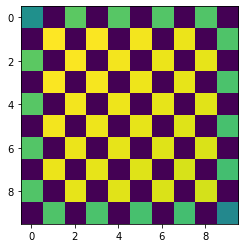

In [120]:
plt.imshow(cs.maps["terrain"][100])

In [173]:
cs.flow(100)

/tmp/ipykernel_3947/1754892680.py:13: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


In [176]:
cs.canvases

{'terrain': array([[-4.32358573e+146,  1.21244332e+147, -1.66661357e+147,
          2.26797280e+147, -2.28167699e+147,  2.49987108e+147,
         -2.07083053e+147,  1.82664171e+147, -1.10699201e+147,
          5.59408642e+146],
        [ 1.21244332e+147, -2.73189402e+147,  3.90127406e+147,
         -5.09351299e+147,  5.33770560e+147, -5.61381981e+147,
          4.84485664e+147, -4.10452112e+147,  2.59996732e+147,
         -1.10707568e+147],
        [-1.66661357e+147,  3.90127406e+147, -6.15675296e+147,
          7.26522186e+147, -8.42161768e+147,  8.00679368e+147,
         -7.64455967e+147,  5.85554190e+147, -4.10503984e+147,
          1.82698586e+147],
        [ 2.26797280e+147, -5.09351299e+147,  7.26522186e+147,
         -9.48551234e+147,  9.93663952e+147, -1.04535713e+148,
          9.01990790e+147, -7.64584241e+147,  4.84617738e+147,
         -2.07160584e+147],
        [-2.28167699e+147,  5.33770560e+147, -8.42161768e+147,
          9.93663952e+147, -1.15179501e+148,  1.09504504e+

In [175]:
cs.maps[key]

[array([[-4.32358573e+146,  1.21244332e+147, -1.66661357e+147,
          2.26797280e+147, -2.28167699e+147,  2.49987108e+147,
         -2.07083053e+147,  1.82664171e+147, -1.10699201e+147,
          5.59408642e+146],
        [ 1.21244332e+147, -2.73189402e+147,  3.90127406e+147,
         -5.09351299e+147,  5.33770560e+147, -5.61381981e+147,
          4.84485664e+147, -4.10452112e+147,  2.59996732e+147,
         -1.10707568e+147],
        [-1.66661357e+147,  3.90127406e+147, -6.15675296e+147,
          7.26522186e+147, -8.42161768e+147,  8.00679368e+147,
         -7.64455967e+147,  5.85554190e+147, -4.10503984e+147,
          1.82698586e+147],
        [ 2.26797280e+147, -5.09351299e+147,  7.26522186e+147,
         -9.48551234e+147,  9.93663952e+147, -1.04535713e+148,
          9.01990790e+147, -7.64584241e+147,  4.84617738e+147,
         -2.07160584e+147],
        [-2.28167699e+147,  5.33770560e+147, -8.42161768e+147,
          9.93663952e+147, -1.15179501e+148,  1.09504504e+148,
      